# Testing DML with kernel regression using singular kernels

In this notebook, we use DML as a dimensionality reduction technique and we regress state-space variables and the projected source terms using kernel regression with singular kernels:

- ``singular_kernel`` $\mathcal{K} \equiv || u ||^{-d} \mathbf{I}\{ ||u|| > 1 \}$ 

- ``singular_kernel_plus`` $\mathcal{K} \equiv || u ||^{-d} [1 - ||u||]^2_+$ 

- ``singular_kernel_minus`` $\mathcal{K} \equiv || u ||^{-d} \mathbf{I}\{ ||u|| \leq 1 \}$ 

- ``cos_singular_kernel`` $\mathcal{K} \equiv || u ||^{-d} cos^2 \Big(\frac{\pi ||u||}{2} \Big) \mathbf{I}\{ ||u|| \leq 1 \}$ 

as per [1], where $|| \cdot ||$ denotes the Euclidean norm and $d$ is the dimensionality of the independent variables matrix (typically 2 or 3).

The goal is to explore how well these singular kernels perform, as compared to using a Gaussian kernel:

- ``gaussian_kernel`` $\mathcal{K} = exp(-0.5 u^2)$

> [1] [Mikhail Belkin, Alexander Rakhlin, Alexandre B. Tsybakov, *Does data interpolation contradict statistical optimality?*, 2018](https://arxiv.org/abs/1806.09471)

***

In [1]:
%run -i ../dml.py
%run -i ../diagnostic.py
%run -i ../regression.py

data_path = '../data-sets/flamelet_data_varying_complexity/'

In [2]:
n_components = 3
scaling = 'pareto'
random_seed = 100

In [3]:
data = pickle.load(open(data_path + 'transient-h2-burke-flamelet-state.p','rb'))
src_terms = pickle.load(open(data_path + 'transient-h2-burke-flamelet-source.p','rb'))
exclude = ['chi_st', 'mixture_fraction', 'P', 'N2', 'AR', 'HE']

names = [name for name in data.keys() if name not in exclude]
X   = np.hstack([data     [name][None].T for name in names])
S_X = np.hstack([src_terms[name][None].T for name in names])

print(names)

['T', 'H', 'H2', 'O', 'OH', 'H2O', 'O2', 'HO2', 'H2O2']


In [4]:
(X_centered_scaled, X_center, X_scale) = preprocess.center_scale(X, scaling=scaling)
S_X_scaled = S_X / X_scale

In [5]:
m = np.loadtxt(data_path + "h2_burke_transient_dml_1.csv", delimiter= ",")
DML_X = X_centered_scaled @ m
DML_S = S_X_scaled @ m

DML_X = DML_X.astype(np.float32)
DML_S = DML_S.astype(np.float32)

DML_X, idx_unique = np.unique(DML_X, return_index=True , axis=0)
DML_S = DML_S[idx_unique,:]
OUTPUT = np.hstack((X[idx_unique,:], DML_S))

print(np.shape(DML_X))
print(np.shape(DML_S))
print(np.shape(OUTPUT))

(n_observations, n_regressed_variables) = OUTPUT.shape

(29250, 3)
(29250, 3)
(29250, 12)


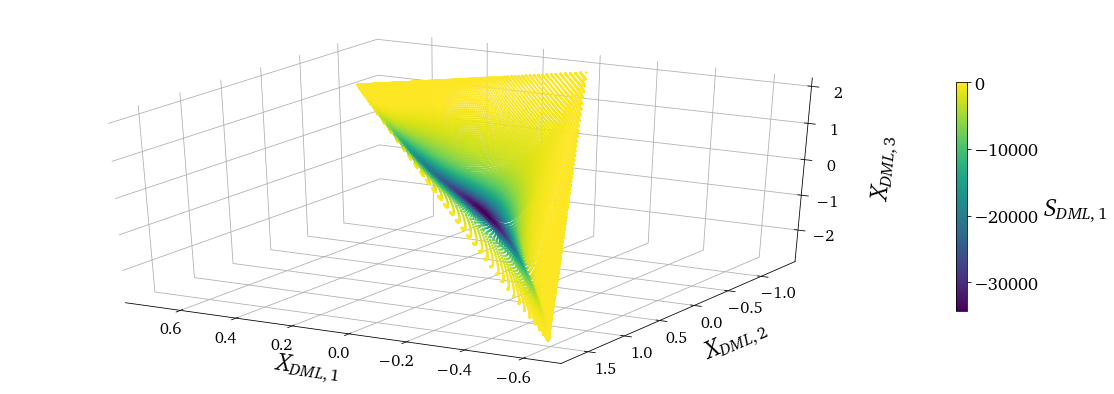

In [6]:
plt = reduction.plot_3d_manifold(DML_X[:,0], DML_X[:,1], DML_X[:,2], color=DML_S[:,0], elev=30, azim=120, x_label='$X_{DML, 1}$', y_label='$X_{DML, 2}$', z_label='$X_{DML, 3}$', color_map='viridis', colorbar_label='$S_{DML, 1}$', figure_size=(20,7))

***

## Run kernel regression

In [7]:
n_neighbors = 100

In [8]:
train_perc = 80
test_perc = 20

idx = np.zeros((n_observations,)).astype(int)
sample_random = preprocess.DataSampler(idx, random_seed=random_seed, verbose=False)
(idx_test, _) = sample_random.random(test_perc)
sample_random.idx_test = idx_test
(idx_train, _) = sample_random.random(train_perc)

DML_X_test = DML_X[idx_test,:]
DML_X_train = DML_X[idx_train,:]

DML_S_test = DML_S[idx_test,:]
DML_S_train = DML_S[idx_train,:]

OUTPUT_test = OUTPUT[idx_test,:]
OUTPUT_train = OUTPUT[idx_train,:]

print(np.shape(OUTPUT))
print(np.shape(OUTPUT_test))
print(np.shape(OUTPUT_train))

(29250, 12)
(5850, 12)
(23400, 12)


#### Use `singular_kernel`:

In [9]:
OUTPUT_test_predicted_singular_kernel = singular_kernel_average(DML_X_train, DML_S_train, n_neighbors, singular_kernel, DML_X_test, DML_S_test, return_error=False)

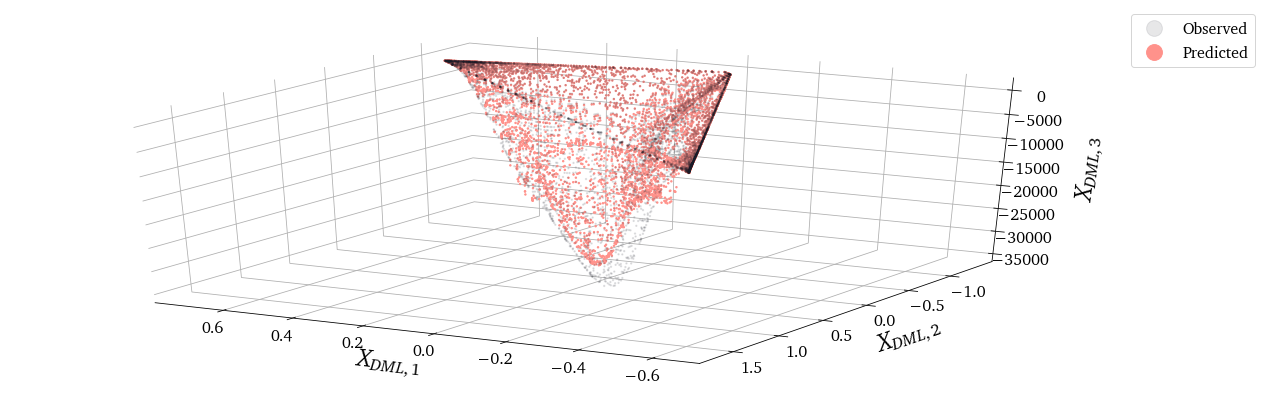

In [10]:
plt = analysis.plot_3d_regression(DML_X_test[:,0], DML_X_test[:,1], DML_S_test[:,0], OUTPUT_test_predicted_singular_kernel[:,0], elev=30, azim=120, x_label='$X_{DML, 1}$', y_label='$X_{DML, 2}$', z_label='$X_{DML, 3}$', figure_size=(20,7))

In [11]:
for i in range(0,3):
    print(analysis.r2value(DML_S_test[:,i], OUTPUT_test_predicted_singular_kernel[:,i]))

0.8137604880688205
0.7928395053455236
0.7181982619656326


#### Use `singular_kernel_plus`:

In [12]:
OUTPUT_test_predicted_singular_kernel_plus = singular_kernel_average(DML_X_train, DML_S_train, n_neighbors, singular_kernel_plus, DML_X_test, DML_S_test, return_error=False)

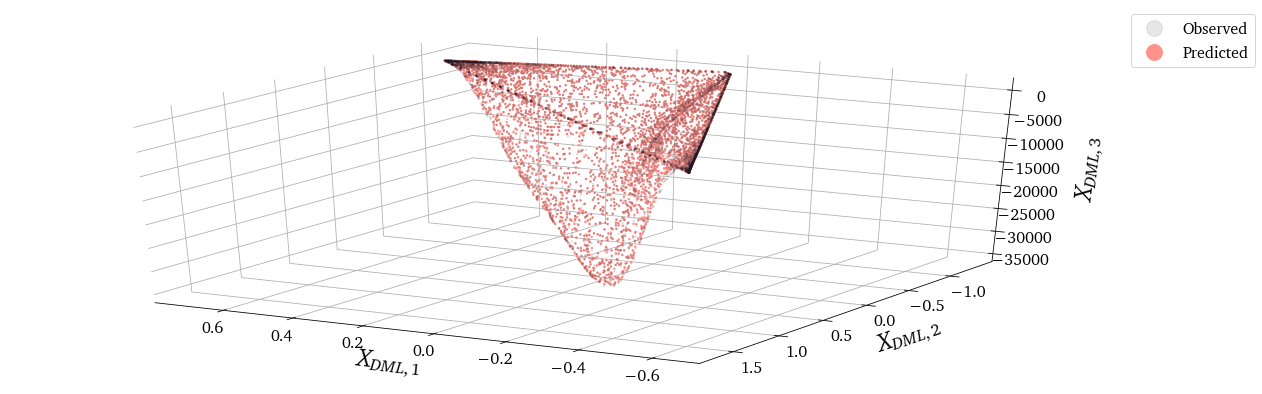

In [13]:
plt = analysis.plot_3d_regression(DML_X_test[:,0], DML_X_test[:,1], DML_S_test[:,0], OUTPUT_test_predicted_singular_kernel_plus[:,0], elev=30, azim=120, x_label='$X_{DML, 1}$', y_label='$X_{DML, 2}$', z_label='$X_{DML, 3}$', figure_size=(20,7))

In [14]:
for i in range(0,3):
    print(analysis.r2value(DML_S_test[:,i], OUTPUT_test_predicted_singular_kernel_plus[:,i]))

0.9981515634423164
0.9974014544825862
0.9951315155380571


#### Use ``singular_kernel_minus``:

In [15]:
OUTPUT_test_predicted_singular_kernel_minus = singular_kernel_average(DML_X_train, DML_S_train, n_neighbors, singular_kernel_minus, DML_X_test, DML_S_test, return_error=False)

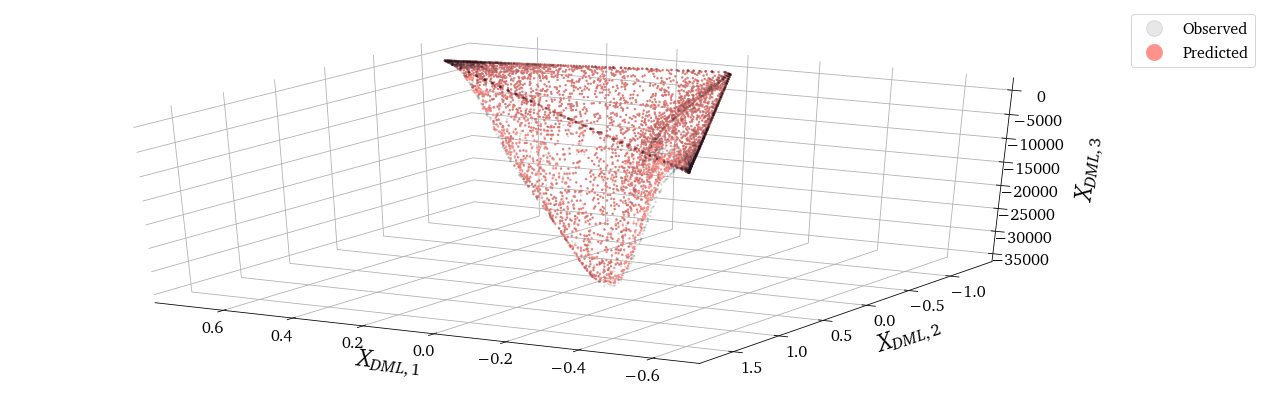

In [16]:
plt = analysis.plot_3d_regression(DML_X_test[:,0], DML_X_test[:,1], DML_S_test[:,0], OUTPUT_test_predicted_singular_kernel_minus[:,0], elev=30, azim=120, x_label='$X_{DML, 1}$', y_label='$X_{DML, 2}$', z_label='$X_{DML, 3}$', figure_size=(20,7))

In [17]:
for i in range(0,3):
    print(analysis.r2value(DML_S_test[:,i], OUTPUT_test_predicted_singular_kernel_minus[:,i]))

0.9963140759026801
0.9949804380448815
0.9926867371396164


#### Use ``cos_singular_kernel``:

In [18]:
OUTPUT_test_predicted_cos_singular_kernel = singular_kernel_average(DML_X_train, DML_S_train, n_neighbors, cos_singular_kernel, DML_X_test, DML_S_test, return_error=False)

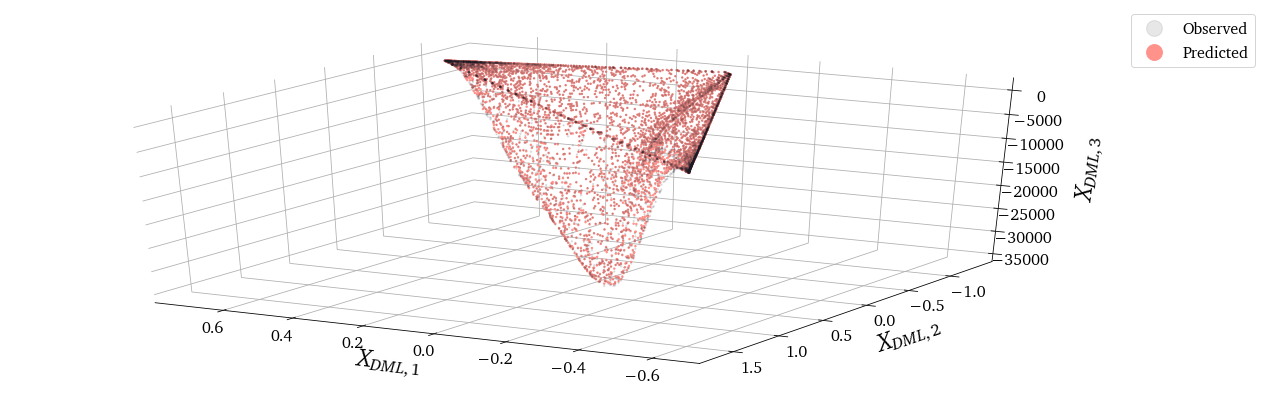

In [19]:
plt = analysis.plot_3d_regression(DML_X_test[:,0], DML_X_test[:,1], DML_S_test[:,0], OUTPUT_test_predicted_cos_singular_kernel[:,0], elev=30, azim=120, x_label='$X_{DML, 1}$', y_label='$X_{DML, 2}$', z_label='$X_{DML, 3}$', figure_size=(20,7))

In [20]:
for i in range(0,3):
    print(analysis.r2value(DML_S_test[:,i], OUTPUT_test_predicted_cos_singular_kernel[:,i]))

0.9979213804006715
0.9970007522735209
0.9945851610720944


***